### Valoración de riesgos de créditos

Imaginemos que trabajamos en un banco. Cuando recibimos una solicitud de préstamo, tenemos que asegurarnos de que, si concedemos el dinero, el cliente podrá devolverlo. Cada solicitud conlleva un riesgo de impago, es decir, que no se devuelva el dinero.

El objetivo de este análisis es puntuar al cliente y evaluar las posibilidades de impago. Si es demasiado alta, rechazamos la solicitud. Este proceso se llama "credit risk scoring".

El aprendizaje automático puede utilizarse para calcular el riesgo. Para ello, necesitamos un conjunto de datos con préstamos, en el que, para cada solicitud, sepamos si se ha devuelto con éxito o no. Con estos datos, se puede construir un modelo para predecir la probabilidad de impago, y se puede utilizar este modelo para evaluar el riesgo de que los futuros prestatarios no devuelvan el dinero.

El problema a resolver es un problema de clasificación binaria. La salida del algoritmo será positiva ("1") si el cliente incumple y negativa ("0") en caso contrario.

Se va a utilizar un conjunto de datos de kaggle(https://www.kaggle.com/datasets/laotse/credit-risk-dataset). 

#### Librerias
Lo primero es cargar las librerias que se van a usar durante el proyecto y cargar el set de datos

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from matplotlib import pyplot as plt

df = pd.read_csv('credit_risk_dataset.csv')

#### Análisis exploratorio de los datos
Lo primero va a ser visualizar la estructura de los datos

In [2]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

Se puede ver que el conjunto de datos está compuesto por las siguientes columnas:
* person_age: edad del cliente
* person_income: sueldo anual del cliente
* personhomeownership: tipo de propiedad de la vivienda
* personemplength: experiencia laboral en años
* loan_intent: Objetivo del préstamo
* loan_grade: Grado del préstamo
* loan_amnt: Cantidad del préstamo
* loanintrate: Tipo de interés
* loan_status: Estado del préstamo (0 es no impago 1 es impago) - **Variable Objetivo**
* loanpercentincome: Porcentaje de ingresos
* cbpersondefaultonfile: Historial de impagos
* cbpresoncredhistlength: Duración del historial de crédito

Cada una de estas variables se analizarán más a fondo a continuación.

In [4]:
# Lo primero que se va a hacer es renombrar algunas variables para facilitar la visualizacion y la comprension
df.columns = ['age', 'income', 'home','job', 'loan_intent', 'loan_grade', 'loan_amnt',
       'int_rate', 'status', 'perc_income','defaults', 'cred_hist']
df.head()

,age,income,home,job,loan_intent,loan_grade,loan_amnt,int_rate,status,perc_income,defaults,cred_hist
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          32581 non-null  int64  
 1   income       32581 non-null  int64  
 2   home         32581 non-null  object 
 3   job          31686 non-null  float64
 4   loan_intent  32581 non-null  object 
 5   loan_grade   32581 non-null  object 
 6   loan_amnt    32581 non-null  int64  
 7   int_rate     29465 non-null  float64
 8   status       32581 non-null  int64  
 9   perc_income  32581 non-null  float64
 10  defaults     32581 non-null  object 
 11  cred_hist    32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
# Se van a eliminar los posibles duplicados
print(df.duplicated().sum())
df = df.drop_duplicates(keep="first")

165


In [7]:
# Se van a visualizar los posibles valores perdidos
print(df.isna().sum())

# Dado el gran numero de entradas que se tienen, se van a eliminar los registros que tienen valores perdidos
print(df.shape)
df = df.dropna()
print(df.shape)

age               0
income            0
home              0
job             887
loan_intent       0
loan_grade        0
loan_amnt         0
int_rate       3095
status            0
perc_income       0
defaults          0
cred_hist         0
dtype: int64
(32416, 12)
(28501, 12)


In [8]:
# A continuación se va a mostrar como se distribuyen los atributos.
# Se va a empezar con los atributos numéricos
df.describe()
# Se van a observar mas detenidamente los que tienen valores muy exagerados(outliers) como age y job

,age,income,job,loan_amnt,int_rate,status,perc_income,cred_hist
count,28501.000000,2.850100e+04,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000
mean,27.738676,6.665441e+04,4.790148,9658.533034,11.045385,0.217115,0.169517,5.800498
std,6.316166,6.237603e+04,4.157462,6329.604672,3.230748,0.412289,0.106410,4.042153
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.950000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


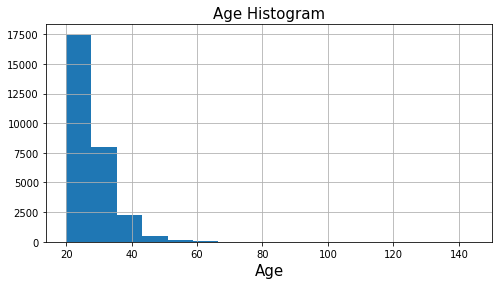

Text(0.5, 1.0, 'Age box plot')

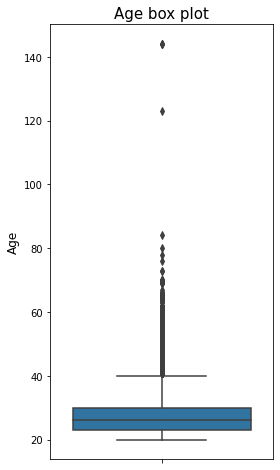

In [9]:
# Atributo "age" o edad en espanol
plt.figure(figsize=(8,4))
df["age"].hist(bins = 16)

plt.title('Age Histogram', fontsize = 15)
plt.xlabel("Age", fontsize=15)
plt.show()

plt.figure(figsize=(4,8))
ax = sns.boxplot(y=df["age"])
ax.set_ylabel("Age", fontsize = 12)
ax.set_title('Age box plot', fontsize=15)

In [10]:
# Se puede observar que la gran mayoria de valores se encuentran entre 20 y 40 anos
# Se va a prodeceder y eliminar los outliers de personas mayores de 90 anos
df = df[df["age"]<90]

Text(0.5, 1.0, 'Job box plot')

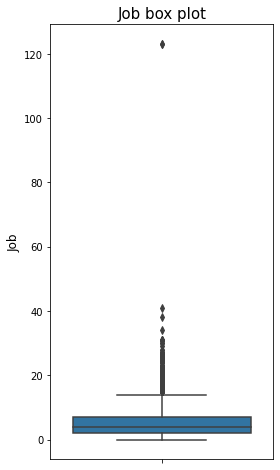

In [11]:
# Atributo "job" o anos trabajados en espanol
plt.figure(figsize=(4,8))
ax = sns.boxplot(y=df["job"])
ax.set_ylabel("Job", fontsize = 12)
ax.set_title('Job box plot', fontsize=15)

In [12]:
# Se va a prodeceder y eliminar los outliers de personas que han trabajado mas de 70 anos
df = df[df["job"]<70]

In [13]:
# Ahora se van a analizar las variables de tipo categorico
print(df["home"].value_counts())
print(df["loan_grade"].value_counts())
print(df["loan_intent"].value_counts())
print(df["defaults"].value_counts())



# Se va a ver como de balanceado esta el data set tambien
print(df["status"].value_counts())
# Se puede observar que se tienen muchos mas casos pagados 22308 que no pagados 6187
# Por lo tanto el data set esta un poco desbalanceado


RENT        14495
MORTGAGE    11733
OWN          2174
OTHER          93
Name: home, dtype: int64
A    9344
B    9092
C    5680
D    3242
E     869
F     209
G      59
Name: loan_grade, dtype: int64
EDUCATION            5668
MEDICAL              5269
VENTURE              4967
PERSONAL             4857
DEBTCONSOLIDATION    4547
HOMEIMPROVEMENT      3187
Name: loan_intent, dtype: int64
N    23406
Y     5089
Name: defaults, dtype: int64
0    22308
1     6187
Name: status, dtype: int64


                  age    income       job  loan_amnt  int_rate    status  \
age          1.000000  0.141449  0.175922   0.056144  0.009504 -0.023267   
income       0.141449  1.000000  0.160593   0.323961 -0.003729 -0.167803   
job          0.175922  0.160593  1.000000   0.108559 -0.058474 -0.086718   
loan_amnt    0.056144  0.323961  0.108559   1.000000  0.146017  0.113965   
int_rate     0.009504 -0.003729 -0.058474   0.146017  1.000000  0.339952   
status      -0.023267 -0.167803 -0.086718   0.113965  0.339952  1.000000   
perc_income -0.039179 -0.297865 -0.059980   0.577505  0.123343  0.379845   
cred_hist    0.877716  0.122296  0.151748   0.045622  0.014520 -0.016485   

             perc_income  cred_hist  
age            -0.039179   0.877716  
income         -0.297865   0.122296  
job            -0.059980   0.151748  
loan_amnt       0.577505   0.045622  
int_rate        0.123343   0.014520  
status          0.379845  -0.016485  
perc_income     1.000000  -0.029422  
cred_hist  

<AxesSubplot:>

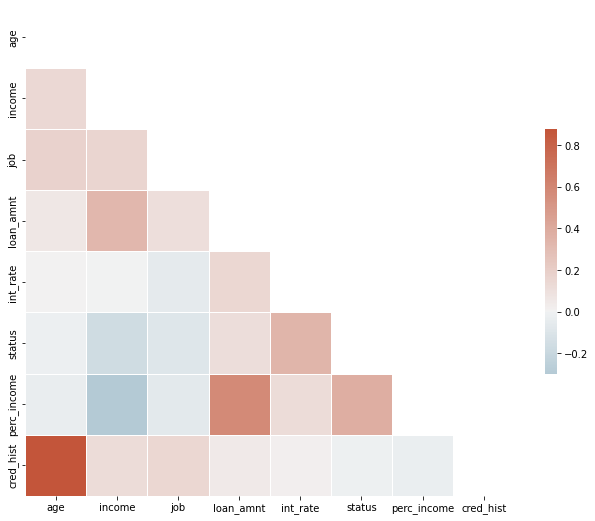

In [14]:
# Para ver la relacion entre variables numericas se va a calcular la matriz de correlaciones
print(df.corr())
# Mascara para el triangulo superior
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# Fijar el tamano de la figuta
plt.subplots(figsize=(11, 9))

# Generar colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar la matriz
sns.heatmap(df.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
# Se observa la mayor correlacion entre la edad y el numero de prestamos pedidos
# Se observa correlacion entre el estado del prestamo, el porcentaje de ingresos y la tasa de interes

In [16]:
# Ahora se va a ver la relacion de las variables categoricas con la objetivo
# Relacion por tipo de casa
pd.crosstab(index=df['home'], columns=df['status'], margins=True)

status,0,1,All
home,,,
MORTGAGE,10250,1483,11733
OTHER,66,27,93
OWN,2029,145,2174
RENT,9963,4532,14495
All,22308,6187,28495


In [17]:
# Relacion con intencion del prestamo
pd.crosstab(index=df['loan_intent'], columns=df['status'], margins=True)

status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3253,1294,4547
EDUCATION,4701,967,5668
HOMEIMPROVEMENT,2367,820,3187
MEDICAL,3851,1418,5269
PERSONAL,3897,960,4857
VENTURE,4239,728,4967
All,22308,6187,28495


In [18]:
# Relacion por historial de impagos
pd.crosstab(index=df['defaults'], columns=df['status'], margins=True)

status,0,1,All
defaults,,,
N,19144,4262,23406
Y,3164,1925,5089
All,22308,6187,28495


In [19]:
# Ahora se van a crear diccionarios para cada una de las variables numericas
home = list(set(df.home))
dict_home = { home[i] : i for i in range(0, len(home) ) }
print(dict_home)

loan_intent = list(set(df.loan_intent))
dict_loan_intent = { loan_intent[i] : i for i in range(0, len(loan_intent) ) }
print(dict_loan_intent)

loan_grade = list(set(df.loan_grade))
dict_loan_grade = { loan_grade[i] : i for i in range(0, len(loan_grade) ) }
print(dict_loan_grade)

defaults = list(set(df.defaults))
dict_defaults = { defaults[i] : i for i in range(0, len(defaults) ) }
print(dict_defaults)

df['home'] = df['home'].map(dict_home) 
df['defaults'] = df['defaults'].map(dict_defaults) 
df['loan_intent'] = df['loan_intent'].map(dict_loan_intent) 
df['loan_grade'] = df['loan_grade'].map(dict_loan_grade) 
df.head(5)



{'RENT': 0, 'OTHER': 1, 'OWN': 2, 'MORTGAGE': 3}
{'MEDICAL': 0, 'EDUCATION': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}
{'F': 0, 'D': 1, 'A': 2, 'E': 3, 'G': 4, 'B': 5, 'C': 6}
{'Y': 0, 'N': 1}


,age,income,home,job,loan_intent,loan_grade,loan_amnt,int_rate,status,perc_income,defaults,cred_hist
1,21,9600,2,5.0,1,5,1000,11.14,0,0.10,1,2
2,25,9600,3,1.0,0,6,5500,12.87,1,0.57,1,3
3,23,65500,0,4.0,0,6,35000,15.23,1,0.53,1,2
4,24,54400,0,8.0,0,6,35000,14.27,1,0.55,0,4
5,21,9900,2,2.0,3,2,2500,7.14,1,0.25,1,2


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# Se importa la funcion que separa el data set
from sklearn.model_selection import train_test_split

X=df.drop("status", axis=1)
y=df['status']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training y 30% test

In [23]:
# Grid de hiperparámetros evaluados
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)


Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
13,0.935025,entropy,NaN,7,150
12,0.934423,entropy,NaN,5,150
21,0.934122,entropy,20.0,5,150
1,0.934072,gini,NaN,7,150


In [24]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print("--------------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_accuracy'], "accuracy")

--------------------------------------------------
Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
0.9350245663290886 : 0.9350245663290886 accuracy


In [25]:
# Se entrena el modelo
modelo_final = RandomForestClassifier(criterion = "gini", max_features = 5, n_estimators = 150)
modelo_final.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=150)

In [27]:
# Precision del modelo

y_pred = modelo_final.predict(X_test)

print(
    classification_report(
        y_true = y_test,
        y_pred = y_pred
    )
)

Precision: 0.9341443443677623
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6690
           1       0.97      0.72      0.83      1859

    accuracy                           0.93      8549
   macro avg       0.95      0.86      0.89      8549
weighted avg       0.94      0.93      0.93      8549



In [28]:
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = y_pred
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = y_pred,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[6653   37]
 [ 526 1333]]

El accuracy de test es: 93.41443443677623 %


In [31]:
# Se define la funcion para guardar objetos
def save_object(filename, object):
    with open(''+filename, 'wb') as file:
        pickle.dump(object, file)

In [32]:
save_object('model.pkl', modelo_final)